# Importing Libraries

In [1]:
# selecting a Data-Structure to handle images effeciently
import numpy as np

# For handling the Folder/Files Structure
import os

# Reading images and performing Image processing
import cv2
from PIL import Image
import tensorflow as tf

# visualizing the images
from matplotlib import pyplot as plt

# GAN model
import tensorflow_hub as hub

# miscellaneous purpose
import math
import time
from skimage.metrics import structural_similarity as ssim
import warnings
warnings.simplefilter("ignore")

# Creating Helper functions 

In [2]:
# SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
SAVED_MODEL_PATH = "esrgan-tf2_1"
model = hub.load(SAVED_MODEL_PATH)

### Image Quality Metrics
creating evaluation functions   

In [ ]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    un_changed = "Shape: "+str(target.shape)+"\n"+"D-Type: "+str(target.dtype)
    # ref = cv2.resize(ref,(target.shape[1],target.shape[0]))
    target = cv2.resize(target,(ref.shape[1],ref.shape[0]))
    return  f'PSNR: {psnr(target,ref)}\nMSE: {mse(target,ref)}\nSSIM: {ssim(target, ref, multichannel=True)}\n{un_changed}'

In [ ]:
def image_preparation_for_model(image=None, path=None):
    ''' Function to read image and prepare it for the model
     to predict the super resolution image as an output'''
    if path:
        hr_image = cv2.imread(path)
        hr_image = cv2.cvtColor(hr_image,cv2.COLOR_BGR2RGB)
    else:
        hr_image = image
        
    hr_size = (np.array(hr_image.shape[:-1]) // 4) * 4

    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    hr_image = tf.expand_dims(hr_image, 0)

    return hr_image

In [ ]:
def convert_to_viewable_image(nd_image):
    image_array = tf.squeeze(nd_image)
    image_array = np.clip(image_array, a_min = 0, a_max = 255)
    return image_array.astype("uint8")

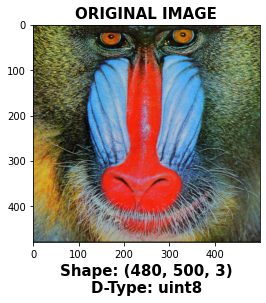

In [ ]:
Test_Image_path = "source/baboon.bmp"
original_image = cv2.imread(Test_Image_path)
original_image = cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
plt.imshow(original_image)
plt.title("ORIGINAL IMAGE",size=15,weight="bold")
text = "Shape: "+str(original_image.shape)+"\n"+"D-Type: "+str(original_image.dtype)
plt.xlabel(text,size=15,weight="bold")
plt.show()

In [ ]:
Test_Image_path = "source/baboon.bmp"
processed_image = image_preparation_for_model(path=Test_Image_path)
print(processed_image.shape,processed_image.dtype)

(1, 480, 500, 3) <dtype: 'float32'>


In [ ]:
start = time.time()
GAN_output = model(processed_image)
print("Time Taken: %f" % (time.time() - start))

NameError: name 'model' is not defined

In [ ]:
gan_out = convert_to_viewable_image(GAN_output)
plt.figure(figsize=(7,7))
plt.imshow(gan_out)
plt.title("SUPER RESOLUTION IMAGE",size=15,weight="bold")
plt.xlabel(compare_images(gan_out,original_image),size=15,weight="bold")
plt.tight_layout()
plt.show()
print(gan_out.shape,gan_out.dtype)

NameError: name 'convert_to_viewable_image' is not defined

In [ ]:
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

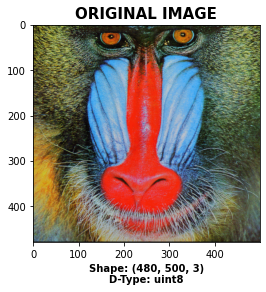

(480, 500, 3) uint8


In [ ]:
plt.imshow(original_image)
plt.title("ORIGINAL IMAGE",size=15,weight="bold")
text = "Shape: "+str(original_image.shape)+"\n"+"D-Type: "+str(original_image.dtype)
plt.xlabel(text,size=10,weight="bold")
plt.show()
print(original_image.shape,original_image.dtype)

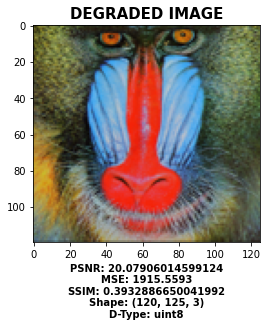

In [ ]:
degraded_image = downscale_image(original_image)
d_img = convert_to_viewable_image(degraded_image)
plt.imshow(d_img)
plt.title("DEGRADED IMAGE",size=15,weight="bold")
plt.xlabel(compare_images(d_img,original_image),size=10,weight="bold")
plt.show()

# inference of LR image

In [ ]:
start = time.time()
# hr_image = image_preparation_for_model(LR_image)
GAN_output = model(degraded_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 2.785300


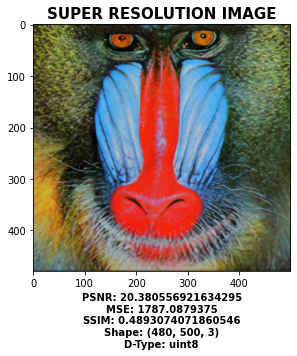

In [ ]:
gan_out = convert_to_viewable_image(GAN_output)
plt.figure(figsize=(5,5))
plt.imshow(gan_out)
plt.title("SUPER RESOLUTION IMAGE",size=15,weight="bold")
plt.xlabel(compare_images(gan_out,original_image),size=10,weight="bold")
plt.tight_layout()
plt.show()

# Uderstanding the results

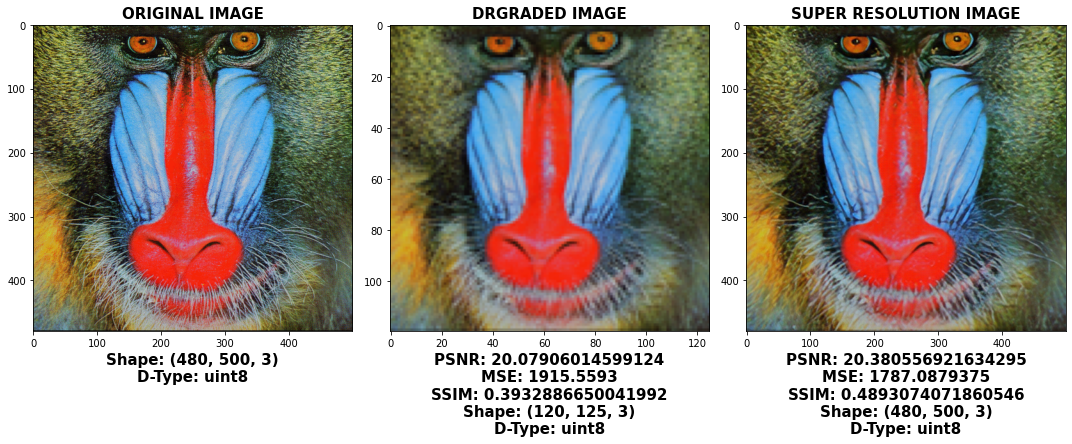

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(1,3,1)
plt.imshow(original_image)
plt.title("ORIGINAL IMAGE",size=15,weight="bold")
text = "Shape: "+str(original_image.shape)+"\n"+"D-Type: "+str(original_image.dtype)
plt.xlabel(text,size=15,weight="bold")

plt.subplot(1,3,2)
d_img = convert_to_viewable_image(degraded_image)
plt.imshow(d_img)
plt.title("DRGRADED IMAGE",size=15,weight="bold")
plt.xlabel(compare_images(d_img,original_image),size=15,weight="bold")

plt.subplot(1,3,3)
gan_out = convert_to_viewable_image(GAN_output)
plt.imshow(gan_out)
plt.title("SUPER RESOLUTION IMAGE",size=15,weight="bold")
plt.xlabel(compare_images(gan_out,original_image),size=15,weight="bold")
plt.tight_layout()
# plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
# print("PSNR: %f" % psnr)

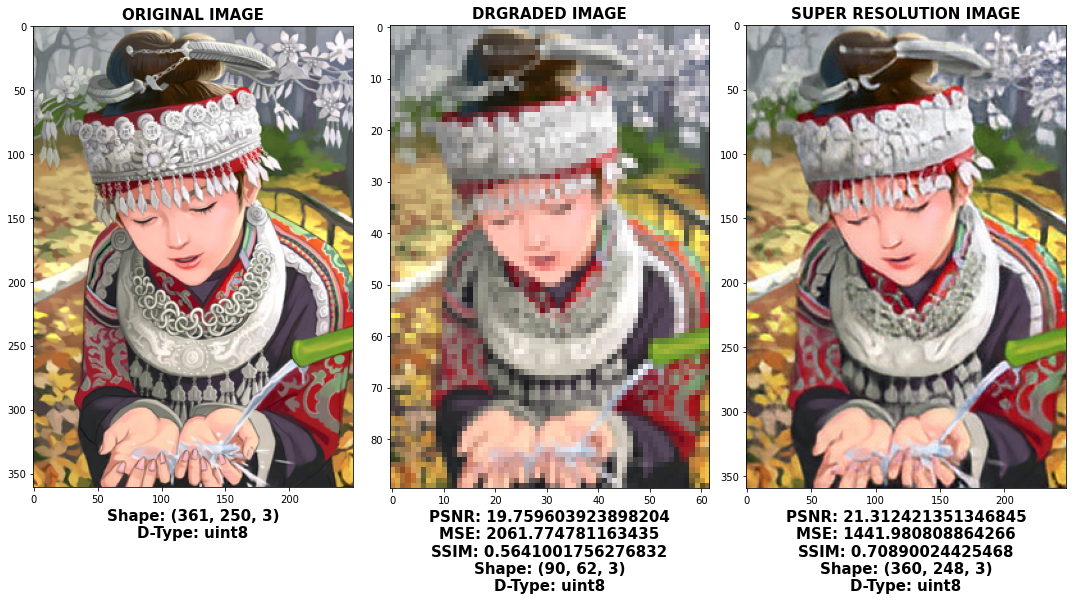

In [ ]:
Test_Image_path = "source/comic.bmp"
original_image = cv2.imread(Test_Image_path)
original_image = cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))

plt.subplot(1,3,1)
plt.imshow(original_image)
plt.title("ORIGINAL IMAGE",size=15,weight="bold")
text = "Shape: "+str(original_image.shape)+"\n"+"D-Type: "+str(original_image.dtype)
plt.xlabel(text,size=15,weight="bold")

plt.subplot(1,3,2)
degraded_image = downscale_image(original_image)
d_img = convert_to_viewable_image(degraded_image)
plt.imshow(d_img)
plt.title("DRGRADED IMAGE",size=15,weight="bold")
plt.xlabel(compare_images(d_img,original_image),size=15,weight="bold")

plt.subplot(1,3,3)
GAN_output = model(degraded_image)
gan_out = convert_to_viewable_image(GAN_output)
plt.imshow(gan_out)
plt.title("SUPER RESOLUTION IMAGE",size=15,weight="bold")
plt.xlabel(compare_images(gan_out,original_image),size=15,weight="bold")

plt.tight_layout()